In [1]:
import numpy as np

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
min(len(w) for w in words)

2

In [4]:
max(len(w) for w in words)

15

In [5]:
for w in words[:3]:
    print(['<s>']+list(w))

['<s>', 'e', 'm', 'm', 'a']
['<s>', 'o', 'l', 'i', 'v', 'i', 'a']
['<s>', 'a', 'v', 'a']


In [6]:
b = {}
for w in words[:]:
    wm = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(wm, wm[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [198]:
sorted(b.items(), key = lambda kv: kv[1], reverse=True)[:20]

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('.', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('.', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '.'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('.', 'j'), 2422)]

In [8]:
import torch

In [9]:
chrs = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chrs)}
stoi['.']=0

itos = {i:s for s,i in stoi.items()}

In [10]:
N = torch.zeros(len(stoi),len(stoi), dtype=torch.int32)

In [11]:
for w in words[:]:
    wm = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(wm, wm[1:]):
        N[stoi[ch1], stoi[ch2]] += 1

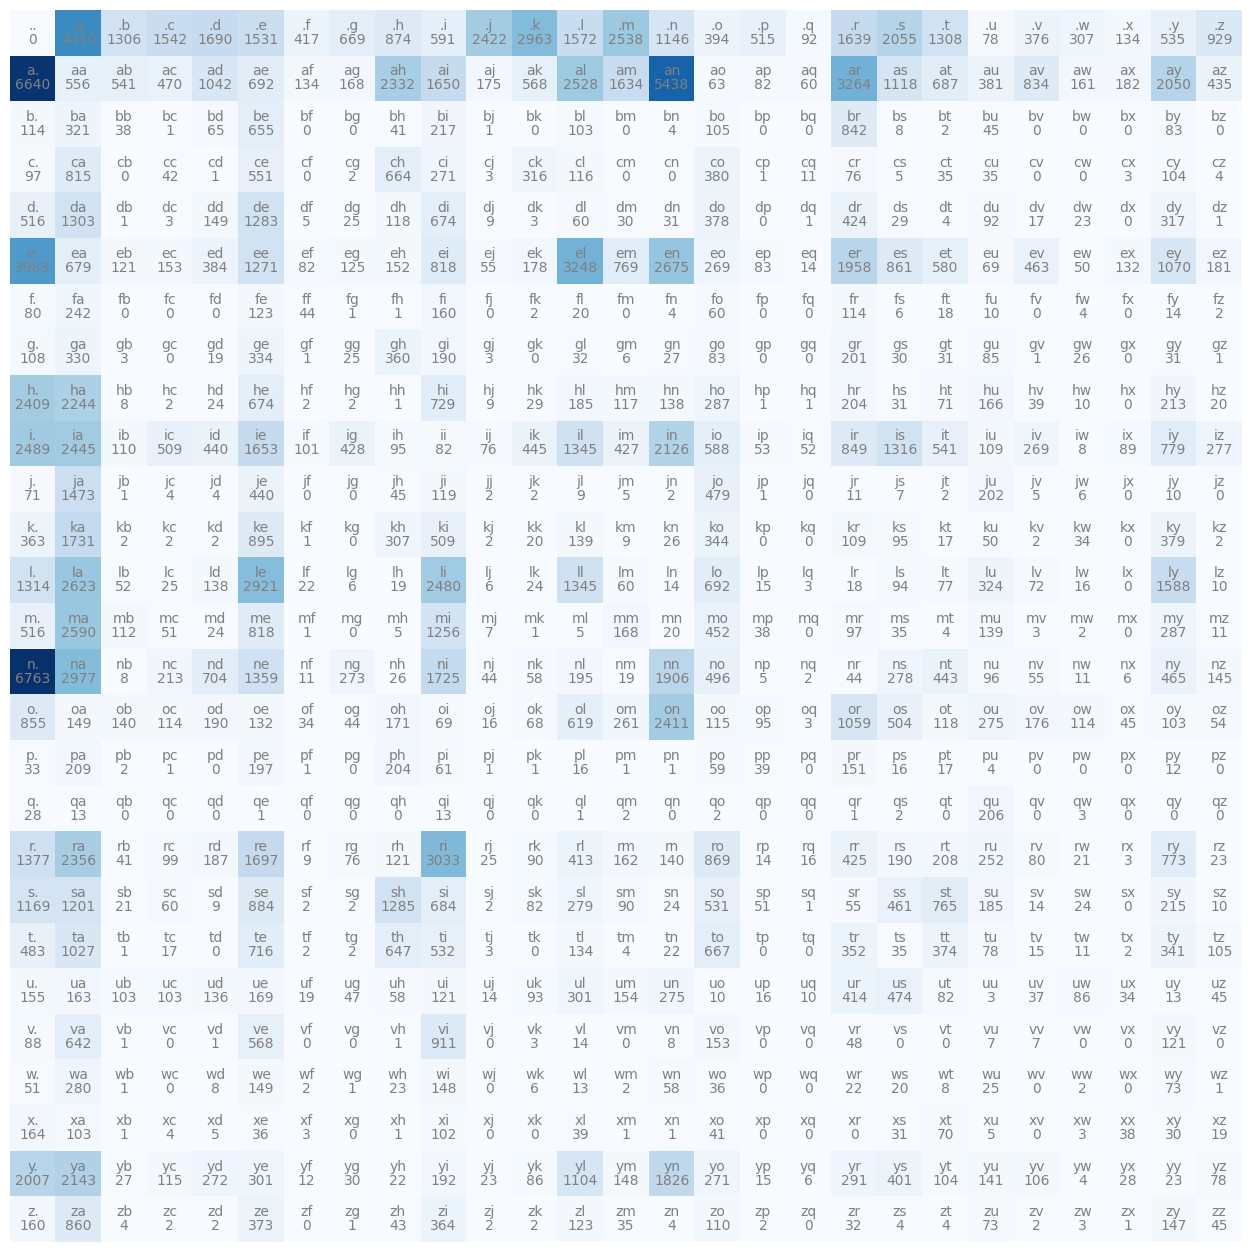

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(len(stoi)):
    for j in range(len(stoi)):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')
plt.axis('off');

In [13]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [14]:
p = N[0].float()
p = p/p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [15]:
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g)
p = p / p.sum()
p

tensor([0.6064, 0.3033, 0.0903])

In [16]:
torch.multinomial(p, num_samples=100, replacement=True, generator=g)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0,
        0, 1, 1, 1])

In [17]:
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'a'

In [18]:
g = torch.Generator().manual_seed(2147483647)
# Highly inefficient! P = torch.tensor( [[n.item()/N[i].sum().item() for n in N[i]] for i in range(len(stoi))] )
P = (N+1).float()
P /= P.sum(axis=1, keepdims = True)

for _ in range(5):
    ix = 0
    out = []
    while True:
        ix = torch.multinomial(P[ix], num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break

    print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.


In [19]:
# ---------------------------------

In [21]:
log_likelihood = 0
n = 0
for w in words:
    wm = ['.'] + list(w) + ['.']
    n += len(wm)-1

    for ch1, ch2 in zip(wm, wm[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        
        prob = P[ix1, ix2]
        log_prob = torch.log(prob)
        log_likelihood += log_prob
        
        # print(f'{ch1}{ch2}  {prob=:.4f} {log_prob=:.4f}')
        
nll = (-log_likelihood)/n
print(f'{nll=}')

nll=tensor(2.4544)


In [128]:
# Each word has (len(word)+1) training samples, including the first and last characters organized as w[i],w[i+1] pairs
# for each word: 
    # create the training samples 
# logits = Dot-product of (len(word), len(stoi)) one-hot vector by (len(stoi), len(stoi)), initiatilized to random value
# counts = logits.exp()
# probs = counts / sum(counts) 
import torch.nn.functional as F

learning_rate = 50 

# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

# random.shuffle(words)
BATCHES = 30 
batch_size = int(len(words)/BATCHES)

In [130]:
for batch_num in range(BATCHES):
    print (f'------START {batch_num=}----------------')

    # fwd pass
    start_w = batch_size * batch_num
    end_w = min(start_w + batch_size, len(words))
    
    nll, nlls = torch.zeros(1,1), torch.zeros(1,1)
    
    for w in words[start_w:end_w]:
        w = ['.'] + list(w) + ['.']

        x, y = [], []
        for chr1, chr2 in zip(w, w[1:]):
                x.append(stoi[chr1])
                y.append(stoi[chr2])

        xs = F.one_hot(torch.tensor(x), num_classes = len(stoi)).float()

        logits = xs @ W
        # print (f'{logits.shape=}')
        counts = logits.exp()
        # print (f'{counts.shape=}')
        probs = counts / torch.sum(counts, dim=1, keepdim=True)
        # print (f'{probs.shape=}')
        # print (f'{probs=}')


        nll = sum([-torch.log(probs[i, ychr]) for i, ychr in enumerate(y)])/len(y)
        # print (f'{"".join(w[1:-1]):20s} nll: {nll.item():.4f}')
        nlls += nll
    
    nlls /= (end_w - start_w)
    print (f'names: {(end_w - start_w)}, nlls: {nlls.item():.4f}')
    
    # zero grad
    W.grad = None
        
    # backward prop
    nlls.backward()
    
    # Nudge weights
    W.data += -learning_rate * W.grad

------START batch_num=0----------------
names: 1067, nlls: 2.5887
------START batch_num=1----------------
names: 1067, nlls: 2.4567
------START batch_num=2----------------
names: 1067, nlls: 2.4354
------START batch_num=3----------------
names: 1067, nlls: 2.4430
------START batch_num=4----------------
names: 1067, nlls: 2.4345
------START batch_num=5----------------
names: 1067, nlls: 2.4188
------START batch_num=6----------------
names: 1067, nlls: 2.4232
------START batch_num=7----------------
names: 1067, nlls: 2.4219
------START batch_num=8----------------
names: 1067, nlls: 2.4075
------START batch_num=9----------------
names: 1067, nlls: 2.4344
------START batch_num=10----------------
names: 1067, nlls: 2.4529
------START batch_num=11----------------
names: 1067, nlls: 2.4275
------START batch_num=12----------------
names: 1067, nlls: 2.4498
------START batch_num=13----------------
names: 1067, nlls: 2.4272
------START batch_num=14----------------
names: 1067, nlls: 2.5027
-----

In [131]:
g = torch.Generator().manual_seed(2147483647)
# Highly inefficient! P = torch.tensor( [[n.item()/N[i].sum().item() for n in N[i]] for i in range(len(stoi))] )
P = W.exp()
P /= P.sum(axis=1, keepdims = True)

for _ in range(5):
    ix = 0
    out = []
    while True:
        ix = torch.multinomial(P[ix], num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break

    print(''.join(out))

nnh.
buvanen.
xrroylat.
konar.
jo.


In [132]:
# -------------- Redo from scratch

In [185]:
import torch
import torch.nn.functional as F 
import random 

words = open('names.txt', 'r').read().splitlines()

# char to int mapping 
chars = sorted(list(set(''.join(words))))
stoi = {ch:i for i, ch in enumerate(chars, 1)}
stoi['.'] = 0
itos = {i:ch for ch,i in stoi.items()}

In [194]:
# set up bi-gram testing pairs - input char as one-hot encoded tensor, and ouput char as list of ints 

# random.shuffle(words)

x, y = [], []
for w in words[:]:
    w = ['.']+list(w)+['.']
    for ch1, ch2 in zip(w, w[1:]):
        x.append(stoi[ch1])
        y.append(stoi[ch2])
        
xs = torch.tensor(x)
xenc = F.one_hot(xs, num_classes=len(stoi)).float()
ys = torch.tensor(y)

print(f'Num of training samples: {len(xs)}')

# set up NN
g = torch.Generator().manual_seed(2147483647)
W = torch.randn( (len(stoi),len(stoi)), requires_grad=True, generator=g )

Num of training samples: 228146


In [195]:
for step in range(250):
    # forward pass
    logits = xenc @ W # Assuming 5 training samples, then (5,27) @ (27,27) = (5,27); positive and negative numbers, all values
    counts = logits.exp() # (5,27); all positive numbers
    probs = counts / counts.sum(axis=1, keepdims=True) # (5, 27); all positive but < 1.0, sum of each row = 1.0
    prob = probs[torch.arange(len(xs)), ys] # (5,); all positive but < 1.0

    # loss function
    loss = -prob.log().mean() + 0.01*(W**2).mean() # (1,); positive
    if step%25==0:
        print(f'Step: {step}, {loss=:.4f}')

    # zero grad 
    W.grad = None

    # backward pass
    loss.backward()

    # parameter update 
    W.data += -50 * W.grad

print(f'Done!')

Step: 0, loss=3.7686
Step: 25, loss=2.5577
Step: 50, loss=2.5099
Step: 75, loss=2.4960
Step: 100, loss=2.4900
Step: 125, loss=2.4868
Step: 150, loss=2.4849
Step: 175, loss=2.4837
Step: 200, loss=2.4830
Step: 225, loss=2.4824
Done!


In [196]:
cs = W.exp()  # counts
Pr = cs/cs.sum(axis=1, keepdims=True) # probabilities 

g = torch.Generator().manual_seed(2147483647)

for _ in range(5):
    ix = 0
    out = []
    while True:
        # xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        # logits = xenc @ W # predict log-counts
        # counts = logits.exp() # counts, equivalent to N
        # p = counts / counts.sum(1, keepdims=True) # probabilities for next character
        
        ix = torch.multinomial(Pr[ix], num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break

    print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchthizarie.


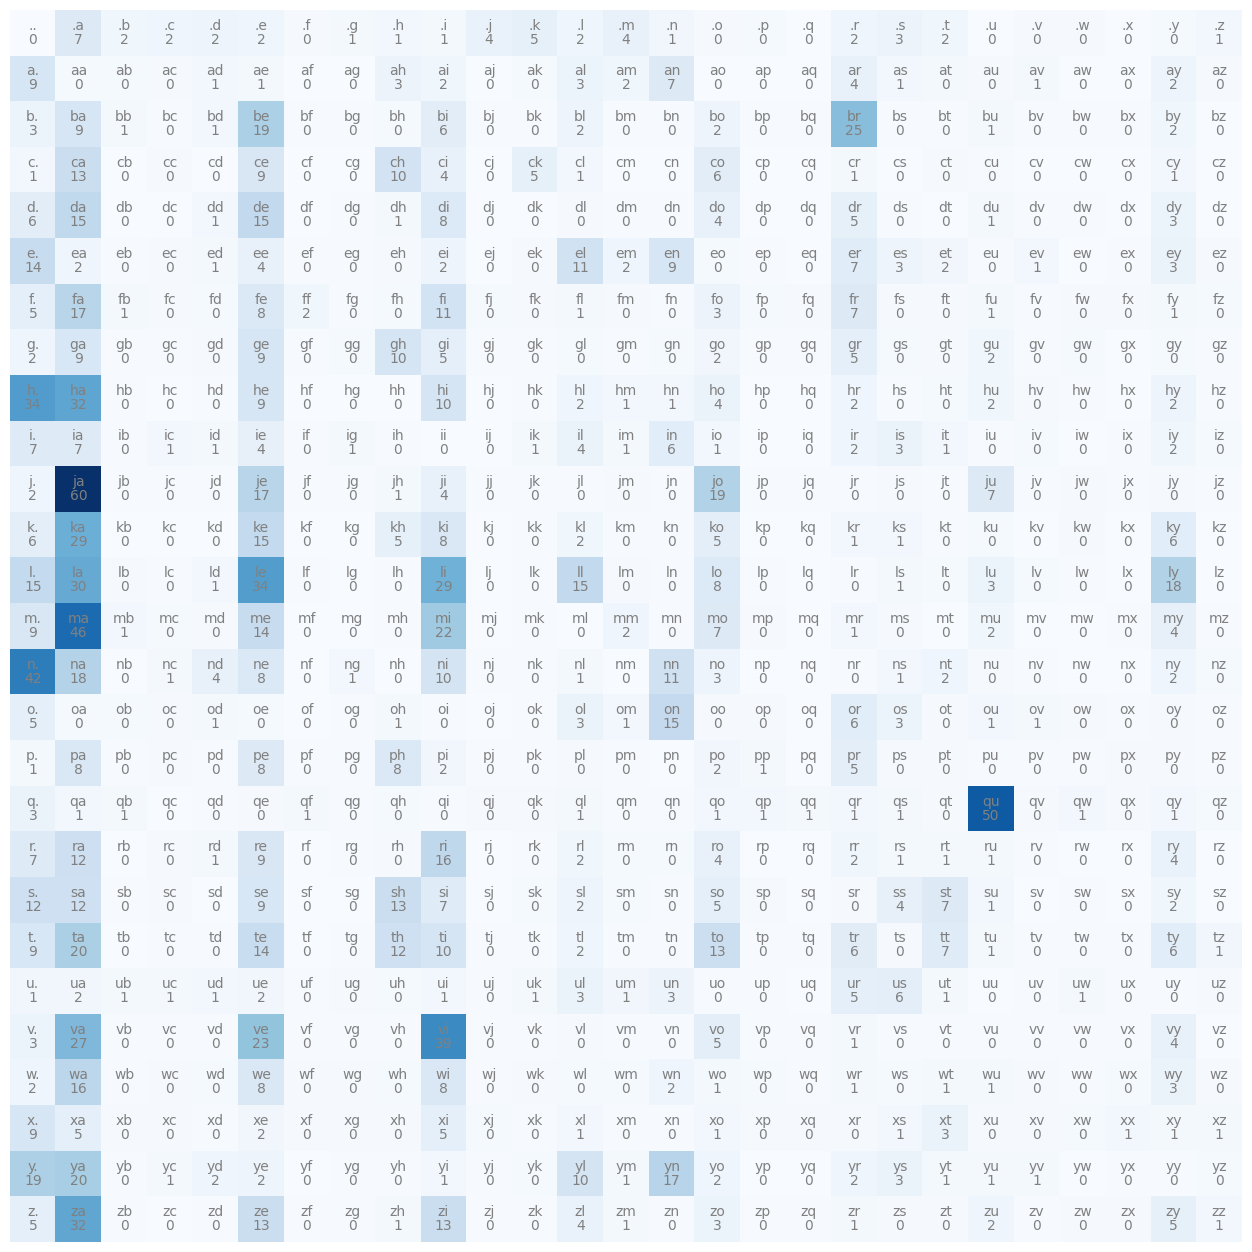

In [197]:
M = W.exp().detach().numpy()

plt.figure(figsize=(16,16))
plt.imshow(M, cmap='Blues')
for i in range(len(stoi)):
    for j in range(len(stoi)):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, int(M[i, j].item()), ha='center', va='top', color='gray')
plt.axis('off');

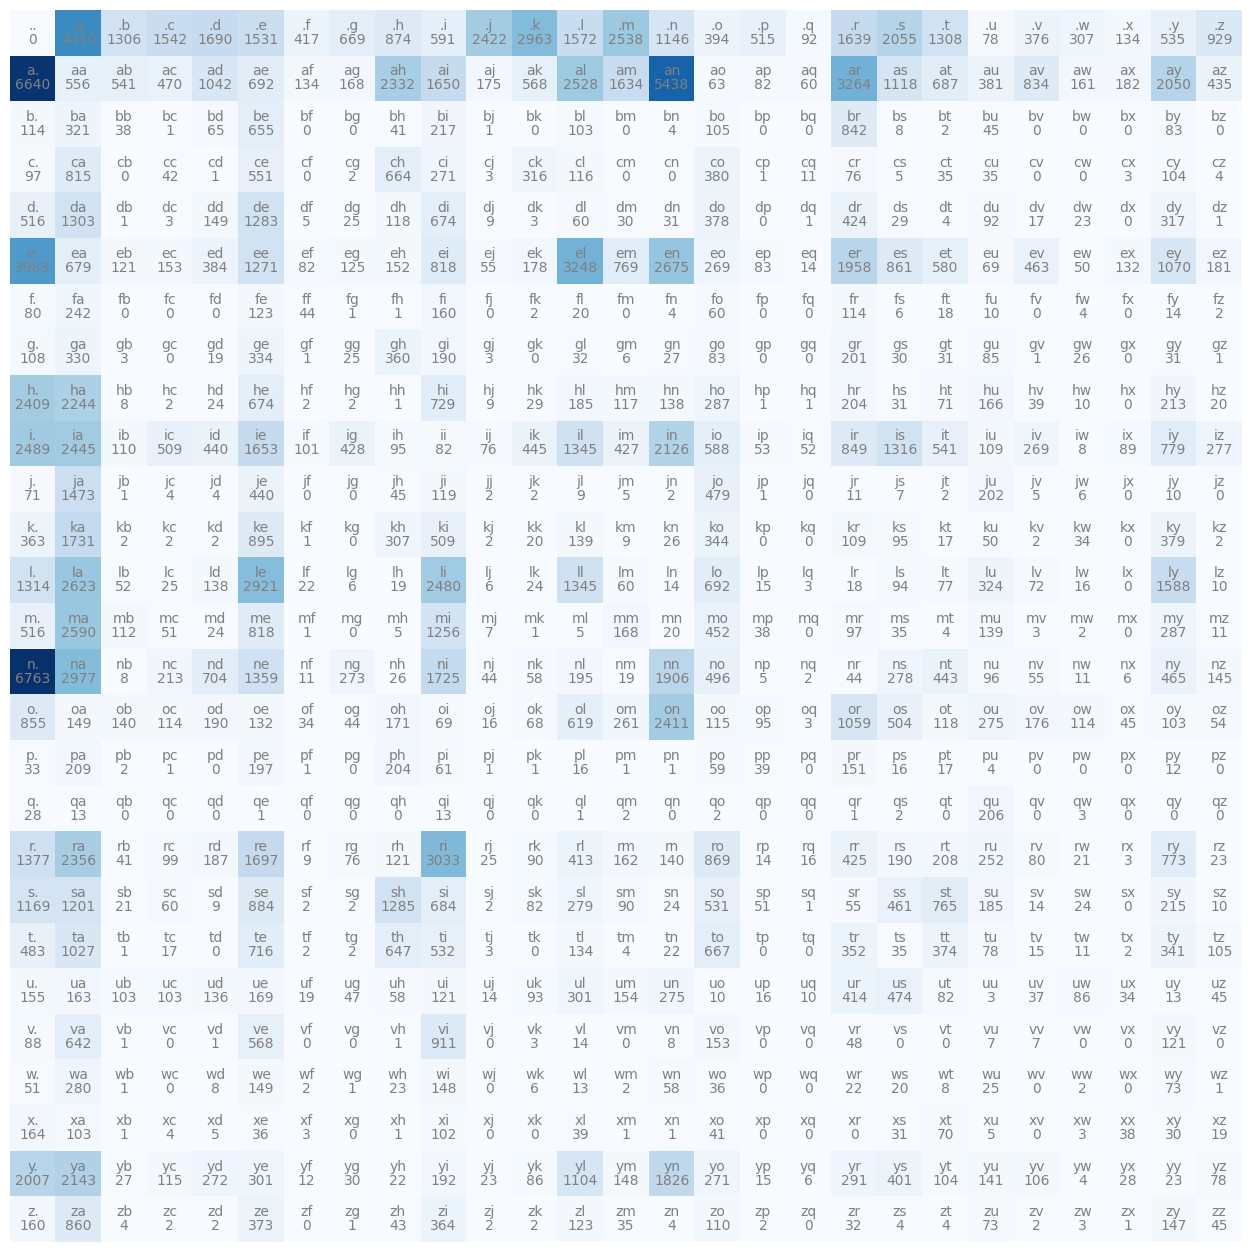

In [138]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(len(stoi)):
    for j in range(len(stoi)):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')
plt.axis('off');